In [159]:
from src import *
import warnings
warnings.filterwarnings("ignore")

import math

## Description

Prediction with neural nets simple MLP for emotion classifications from gradients "to specify what we extract exactly"
OR 
predict intensity values group level during specific movie
GOAL: Predict class of emotions from extracted features of group level gradients 

## Table of Contents
- [Predictive within Same Movie]()
    - [Features Preparation](#feature)
    - [NN Model](#nn)
    - [Train and Prediction](#tpred)

## Predictive within Same Movie

<a class="anchor" id="feature"></a>
### Feature Preparation

In [4]:
networks = list(index2region.keys())

select   = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Contempt','Anxiety', \
             'Satisfaction','Shame','Surprise','Love','Sad']

In [6]:
# extract from emoBIDS intensity values ?
emo_df = pd.read_csv('./data/emotion_compileBIDS.csv')

In [7]:
eg    = 'W_Chatter13.csv'
eg_df = emo_df[emo_df.filename == eg]


select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']

emo_array = []
for emo in eg_df.item.unique():
    if emo in select:
        emo_array.append(np.array(eg_df[eg_df.item == emo].score))

emo_array = np.asarray(emo_array)

In [32]:
# Remove reduncdant emotions, meaning colinear vectors
colinear = (np.abs(FC(emo_array.T)) - np.eye(13)) > 0.80 # arbitrary thresh
keep = []
for i in range(len(colinear)):
    redundant = np.where(colinear[i])[0]
    if np.sum([r in keep for r in redundant]) == 0:
        keep.append(i)
    else:
        print(i)
keep       = np.array(keep)
decolinear = emo_array[keep]

7
8


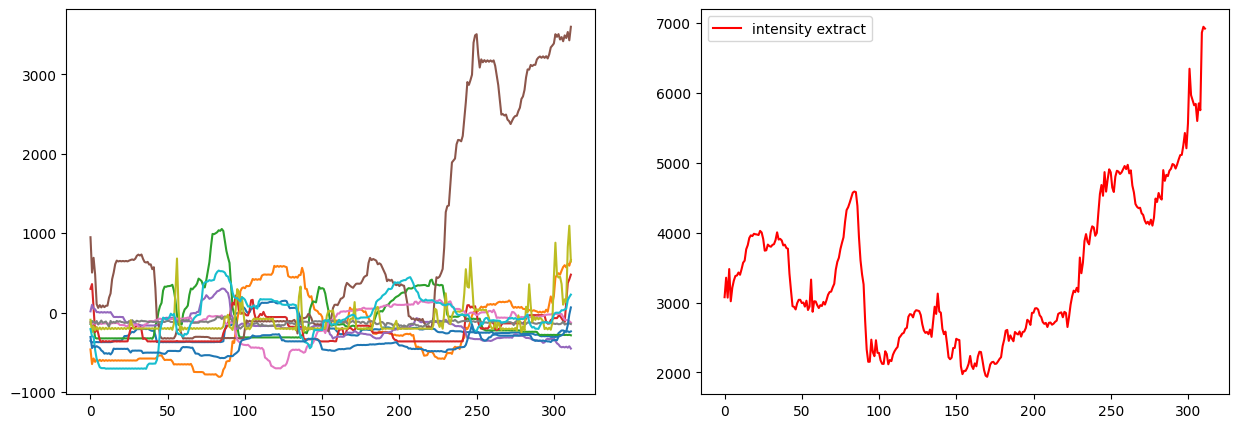

In [50]:
# selected gradients moments?
# predict moments of gradients 
intensity = np.abs(decolinear).sum(axis=0)

fig, ax   = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(decolinear.T)
ax[1].plot(intensity, c='r', label='intensity extract')
ax[1].legend()
plt.show()

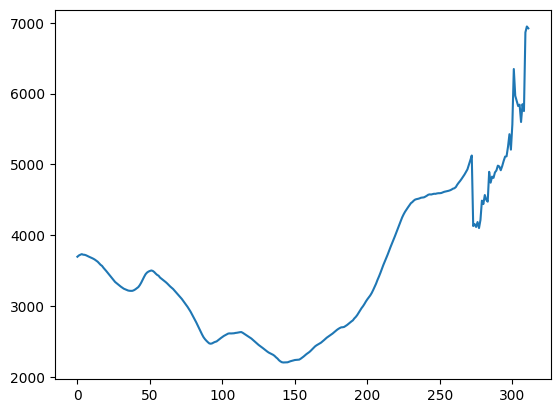

In [59]:
ws = 40
featureY = overlap_add(intensity, wsize=ws, pad=True)
plt.plot(featureY)

In [81]:
# load dynamic gradients
featureX = load('./resources/dynamic_grad/group_level/Chatter_40_grad.pkl')[0][:,:,:3]
# featureX = featureX.reshape(len(featureX), -1)

### NN Model

In [88]:
import os
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split


In [92]:
x_train, x_valid, y_train, y_valid = train_test_split(featureX, featureY, test_size=0.2, random_state=93)

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [87]:
device

device(type='cpu')

In [129]:
x_train = torch.tensor(x_train).to(device).type(torch.FloatTensor)
x_valid = torch.tensor(x_valid).to(device).type(torch.FloatTensor)
y_train = torch.tensor(y_train).to(device).type(torch.FloatTensor)
y_valid = torch.tensor(y_valid).to(device).type(torch.FloatTensor)

In [131]:
x_train.dtype

torch.float32

NOTE USEFUL: sklearn.utils.shuffle

In [186]:
import torch.nn.functional as F
import torch.optim as optim


class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(400 * 3, 32)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,1)

    def forward(self, x):
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.sigmoid(self.fc3(x))
        x = self.fc3(x)
        
        x = x.squeeze(1)

        return x

### Train and Validation

In [210]:
nb_epoch   = 10000
batch_size = 60

In [211]:
mlp     = MLP().to(device)
loss_fn = nn.MSELoss()
# optimizer = optim.SGD(mlp.parameters(),  lr=1e-7)
optimizer = optim.SGD(mlp.parameters(),  lr=1e-6)

logs = {'train': [], 'validation': []}

size = x_train.shape[0]
for epoch in range(nb_epoch):
    
    for i in range(math.ceil(size/batch_size)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = x_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mlp(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # print statistics for train and validation set
    with torch.no_grad():
        # train
        train_pred = mlp(x_train)
        train_loss = loss_fn(train_pred, y_train) / y_train.shape[0]
        
        # validation 
        val_pred = mlp(x_valid)
        val_loss = loss_fn(val_pred, y_valid) / y_valid.shape[0]
        
        if epoch % 100 == 0:
            print("##################")
            print("Epoch {} MSE loss per sample is {} (Train)".format(epoch, train_loss))
            print("Epoch {} MSE loss per sample is {} (Validation)\n".format(epoch, val_loss))
        
        logs['train'].append(train_loss)
        logs['validation'].append(val_loss)

##################
Epoch 0 MSE loss per sample is 39851.234375 (Train)
Epoch 0 MSE loss per sample is 163621.9375 (Validation)

##################
Epoch 100 MSE loss per sample is 2972.27587890625 (Train)
Epoch 100 MSE loss per sample is 13745.0283203125 (Validation)

##################
Epoch 200 MSE loss per sample is 21963.96875 (Train)
Epoch 200 MSE loss per sample is 93523.984375 (Validation)

##################
Epoch 300 MSE loss per sample is 15401.2265625 (Train)
Epoch 300 MSE loss per sample is 67829.5 (Validation)

##################
Epoch 400 MSE loss per sample is 931.4661254882812 (Train)
Epoch 400 MSE loss per sample is 3393.703125 (Validation)

##################
Epoch 500 MSE loss per sample is 7742.63427734375 (Train)
Epoch 500 MSE loss per sample is 34770.73828125 (Validation)

##################
Epoch 600 MSE loss per sample is 5522.76513671875 (Train)
Epoch 600 MSE loss per sample is 24891.791015625 (Validation)

##################
Epoch 700 MSE loss per sample is 18

##################
Epoch 5800 MSE loss per sample is 40.12800598144531 (Train)
Epoch 5800 MSE loss per sample is 190.732666015625 (Validation)

##################
Epoch 5900 MSE loss per sample is 40.59548568725586 (Train)
Epoch 5900 MSE loss per sample is 197.47219848632812 (Validation)

##################
Epoch 6000 MSE loss per sample is 38.60794448852539 (Train)
Epoch 6000 MSE loss per sample is 184.07559204101562 (Validation)

##################
Epoch 6100 MSE loss per sample is 40.909000396728516 (Train)
Epoch 6100 MSE loss per sample is 203.85252380371094 (Validation)

##################
Epoch 6200 MSE loss per sample is 37.949951171875 (Train)
Epoch 6200 MSE loss per sample is 184.39169311523438 (Validation)

##################
Epoch 6300 MSE loss per sample is 37.00935745239258 (Train)
Epoch 6300 MSE loss per sample is 178.3343048095703 (Validation)

##################
Epoch 6400 MSE loss per sample is 38.43244171142578 (Train)
Epoch 6400 MSE loss per sample is 189.42738342285

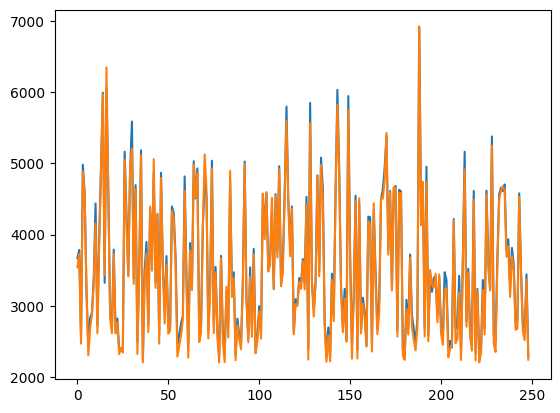

In [212]:
plt.plot(train_pred)
plt.plot(y_train)

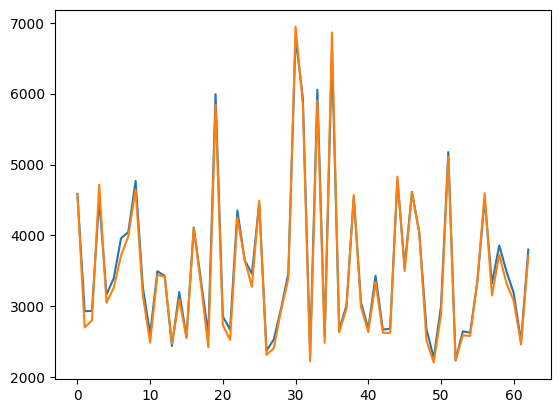

In [213]:
plt.plot(val_pred)
plt.plot(y_valid)

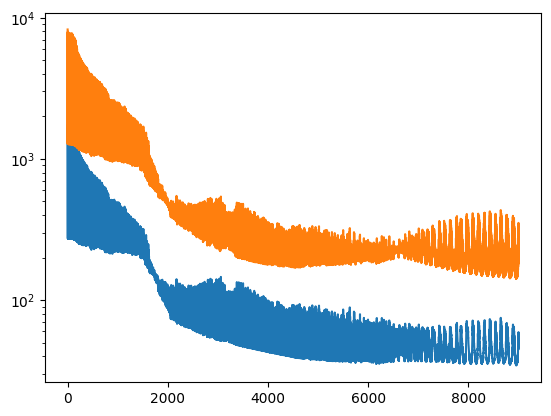

In [214]:
plt.plot(logs['train'][1000:])
plt.plot(logs['validation'][1000:])
plt.yscale('log')